# Personal Information
Name: **Ronald Vlaar**

StudentID: **12871524**

Email: [**ronald.vlaar@student.uva.nl**]

Submitted on: **22.03.2024**

Github: https://github.com/ronaldvlaar/prototype_segmentation

# Data Context

The first dataset used is the Cityscapes dataset. This dataset can be downloaded from https://www.cityscapes-dataset.com/downloads/. The gtFine_trainvaltest.zip and leftlmgbit_trainvaltest.zip are needed. The domain is image segmentation.


The second dataset is an augmented version of the PASCAL VOC 2012 dataset. The domain is image segmentation. Instruction for downloading the data may be found here https://github.com/kazuto1011/deeplab-pytorch/blob/master/data/datasets/voc12/README.md. The augmented variant (SegmentationAug and SegmentationClassAug) should be downloaded.



The data will be used to train and evaluate a model for image segmentation. We want to improve the ProtoSeg (https://arxiv.org/pdf/2301.12276.pdf) baseline model for image segmentation. This model uses part-prototypes for making its predictions explainable, in contrast too deep learning methods like U-Net and DeepLab.

# Data Description

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import seaborn_image as isns

### Data Loading

The data is loaded and preprocessed using the segmentation.preprocess_cityscapes and segmentation.preprocess_pascal modules from ProtoSeg (https://github.com/gmum/proto-segmentation).

In [3]:
# Mapping from protoseg
"""
Some constants related to Cityscapes and PASCAL datasets
"""

# Taken from deeplabv2 trained on ImageNet
CITYSCAPES_MEAN = [0.485, 0.456, 0.406]
CITYSCAPES_STD = [0.229, 0.224, 0.225]

# Mapping of IDs to labels
# We follow https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
# We merge 'void' classes into one but other classes stay the same

CITYSCAPES_ID_2_LABEL = {
    0: 'void',
    1: 'void',
    2: 'void',
    3: 'void',
    4: 'void',
    5: 'void',
    6: 'void',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
    -1: 'license plate'
}

CITYSCAPES_MAP = {
    0: 255,
    1: 255,
    2: 255,
    3: 255,
    4: 255,
    5: 255,
    6: 255,
    7: 0,
    8: 1,
    9: 255,
    10: 255,
    11: 2,
    12: 3,
    13: 4,
    14: 255,
    15: 255,
    16: 255,
    17: 5,
    18: 255,
    19: 6,
    20: 7,
    21: 8,
    22: 9,
    23: 10,
    24: 11,
    25: 12,
    26: 13,
    27: 14,
    28: 15,
    29: 255,
    30: 255,
    31: 16,
    32: 17,
    33: 18,
    -1: -1,
}

CITYSCAPES_CATEGORIES = [
    'void',
    'road',
    'sidewalk',
    'parking',
    'rail track',
    'building',
    'wall',
    'fence',
    'guard rail',
    'bridge',
    'tunnel',
    'pole',
    'polegroup',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'caravan',
    'trailer',
    'train',
    'motorcycle',
    'bicycle',
    'license plate'
]

CITYSCAPES_19_EVAL_CATEGORIES = {
    0: 0,
    1: 1,
    2: 2,
    3: 0,
    4: 0,
    5: 3,
    6: 4,
    7: 5,
    8: 0,
    9: 0,
    10: 0,
    11: 6,
    12: 0,
    13: 7,
    14: 8,
    15: 9,
    16: 10,
    17: 11,
    18: 12,
    19: 13,
    20: 14,
    21: 15,
    22: 16,
    23: 0,
    24: 0,
    25: 17,
    26: 18,
    27: 19,
    28: 0,
}

PASCAL_ID_MAPPING = {
    255: 0,
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5,
    5: 6,
    6: 7,
    7: 8,
    8: 9,
    9: 10,
    10: 11,
    11: 12,
    12: 13,
    13: 14,
    14: 15,
    15: 16,
    16: 17,
    17: 18,
    18: 19,
    19: 20,
    20: 21
}

PASCAL_CATEGORIES = [
    'void',
    '__background__',
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

In [82]:
print(len(CITYSCAPES_CATEGORIES))

cs19map = dict()

CITYSCAPES_19_REV = {v : k for k, v in CITYSCAPES_19_EVAL_CATEGORIES.items()}

for i in range(len(CITYSCAPES_19_EVAL_CATEGORIES)):
    cs19 = CITYSCAPES_19_EVAL_CATEGORIES[i]

    print(CITYSCAPES_CATEGORIES[i], CITYSCAPES_CATEGORIES[cs19])
    cs19map[CITYSCAPES_CATEGORIES[i]] = CITYSCAPES_CATEGORIES[cs19]


29
void void
road road
sidewalk sidewalk
parking void
rail track void
building parking
wall rail track
fence building
guard rail void
bridge void
tunnel void
pole wall
polegroup void
traffic light fence
traffic sign guard rail
vegetation bridge
terrain tunnel
sky pole
person polegroup
rider traffic light
car traffic sign
truck vegetation
bus terrain
caravan void
trailer void
train sky
motorcycle person
bicycle rider
license plate void


In [76]:
cs19map

{'void': 'void',
 'road': 'road',
 'sidewalk': 'sidewalk',
 'parking': 'void',
 'rail track': 'void',
 'building': 'parking',
 'wall': 'rail track',
 'fence': 'building',
 'guard rail': 'void',
 'bridge': 'void',
 'tunnel': 'void',
 'pole': 'wall',
 'polegroup': 'void',
 'traffic light': 'fence',
 'traffic sign': 'guard rail',
 'vegetation': 'bridge',
 'terrain': 'tunnel',
 'sky': 'pole',
 'person': 'polegroup',
 'rider': 'traffic light',
 'car': 'traffic sign',
 'truck': 'vegetation',
 'bus': 'terrain',
 'caravan': 'void',
 'trailer': 'void',
 'train': 'sky',
 'motorcycle': 'person',
 'bicycle': 'rider',
 'license plate': 'void'}

In [4]:
CATEGORY_2_TRAIN_ID = {cat: i for i, cat in enumerate(CITYSCAPES_CATEGORIES)}
ID_2_TRAIN_ID = {i: CATEGORY_2_TRAIN_ID[cat] for i, cat in CITYSCAPES_ID_2_LABEL.items()}
id_2_train_id_vec = np.vectorize(ID_2_TRAIN_ID.get)

print(ID_2_TRAIN_ID)
print(len(ID_2_TRAIN_ID))

print(len(set(ID_2_TRAIN_ID.values())))
print(set(ID_2_TRAIN_ID.values()))
len(PASCAL_CATEGORIES)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 16: 10, 17: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 26, 33: 27, -1: 28}
35
29
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}


22

In [67]:
# Converters
OUR_ID_2_SOURCE_ID = {k: v for k, v in CITYSCAPES_19_EVAL_CATEGORIES.items()}
OUR_ID_2_SOURCE_ID[0] = 0
rev_origin = {v: k for k, v in CITYSCAPES_ID_2_LABEL.items()}
OUR_ID_2_SOURCE_ID = {k: rev_origin[CITYSCAPES_CATEGORIES[v]] for k, v in OUR_ID_2_SOURCE_ID.items()}
# convert_cityscapes = np.vectorize(OUR_ID_2_SOURCE_ID.get)

convert_cityscapes = np.vectorize(CITYSCAPES_19_EVAL_CATEGORIES.get)
convert_pascal = np.vectorize(PASCAL_ID_MAPPING.get)

In [69]:
convert_cityscapes(np.array([1,2,3])), convert_pascal(np.array([1,2,3]))

(array([1, 2, 0]), array([2, 3, 4]))

### Analysis 1: 
Below we show an instance of an input image and the ground truth for both the PASCAL VOC 12 and cityscape datasets.

In [7]:
def plot_images(im1_path, im1_title, im2_path, im2_title):
    print(im1_path, im2_path)
    # Load .npy images
    image1 = np.load(im1_path) if im1_path[-3:] == 'npy' else np.array(mpimg.imread(im1_path))
    image2 = np.load(im2_path) if im2_path[-3:] == 'npy' else np.array(mpimg.imread(im2_path))

    # Plotting
    fig, ax =plt.subplots(1, 2)

    ax[0].imshow(image1)
    ax[0].set_title(im1_title)

    ax[1].imshow(image2)
    ax[1].set_title(im2_title)

    # plt.subplot(1, 2, 1)
    # isns.imgplot(image1)
    # plt.title(im1_title)

    # plt.subplot(1, 2, 2)
    # isns.imgplot(image2)
    # plt.title(im2_title)

    plt.tight_layout()
    plt.show()

PASCAL VOC12

../VOC12/img_with_margin_0/train/2007_000032.npy ../VOC12/annotations/train_aug/2007_000032.npy


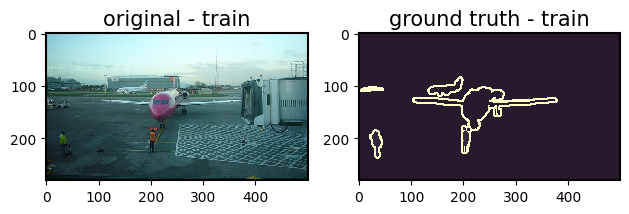

categories in sample 4
categories: void, __background__, aeroplane, person


In [8]:
# File paths of the .npy images
root = '../VOC12/annotations/'
test = root+' test/'
train = root+'train/'
train_aug = root+'train_aug/'
val = root+'val/'

root_src = '../VOC12/img_with_margin_0/'
test_src = root_src+' test/'
train_src = root_src+'train/'
train_aug_src = root_src+'train_aug/'
val_src = root_src+'val/'
f = '2007_000032.npy'

plot_images(train_src+f, 'original - train', train_aug+f, 'ground truth - train')

label = np.load(train_aug+f).astype(np.uint8)

categories = np.array(PASCAL_CATEGORIES)[np.unique(convert_pascal(label))]
print('categories in sample', len(categories))
print('categories:', ', '.join(categories))

Cityscapes

../cityscapes/img_with_margin_0/train/jena_000118_000019.png ../cityscapes/annotations/train/jena_000118_000019.npy


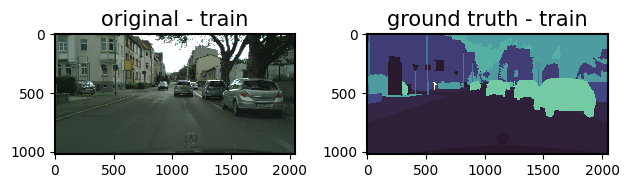

2
[ 0  1  2  5  6 11 14 15 16 17 18 20 27] ['void' 'road' 'sidewalk' 'building' 'wall' 'pole' 'traffic sign'
 'vegetation' 'terrain' 'sky' 'person' 'car' 'bicycle']
categories in sample 13
categories: void, road, sidewalk, parking, rail track, wall, guard rail, bridge, tunnel, pole, polegroup, traffic sign, rider


In [70]:
cs_root = '../cityscapes/annotations/'
cs_test = cs_root+' test/'
cs_train = cs_root+'train/'
cs_val = cs_root+'val/'

cs_root_src = '../cityscapes/img_with_margin_0/'
cs_test_src = cs_root_src+' test/'
cs_train_src = cs_root_src+'train/'
cs_val_src = cs_root_src+'val/'
f = 'aachen_000000_000019.npy'
f= 'cologne_000140_000019.npy'
f='jena_000118_000019.npy'

plot_images(cs_train_src+f[:-3]+'png', 'original - train', cs_train+f, 'ground truth - train')
label = np.load(cs_train+f).astype(np.uint8)

print(label.ndim)
print(np.unique(label), np.array(CITYSCAPES_CATEGORIES)[np.unique(label)])
categories = np.array(CITYSCAPES_CATEGORIES)[np.unique(convert_cityscapes(label))]
print('categories in sample', len(categories))
print('categories:', ', '.join(categories))

In [10]:
import os

files = os.listdir(cs_train)
files

mmin = float('inf')
mmax = 0
for f in files:
    path=cs_train+f
    label=np.unique(np.load(path).astype(np.uint8))
    
    # print(label)
    # print(max(label))
    mmax = max(label) if max(label) > mmax else mmax
    mmin = min(label) if min(label) < mmin else mmin
    print(np.unique(label))
    # print(np.array(CITYSCAPES_CATEGORIES)[np.unique(label)])

print(mmin, mmax)
    

[ 0  1  2  5 11 14 15 16 17 18 19 20 27]
[  0   1   3   4   7   8  11  17  20  21  22  23 255]
[ 0  1  2  5  6  7 11 13 14 15 16 17 20]
[  0   1   3   4   5   6   7   8  11  12  13  17  19  20  21  22  23 255]
[ 0  1  2  5  7 11 13 14 15 16 17 18 20 27]
[  0   1   3   4   5   6   7   8  11  13  17  19  20  21  22  23  26 255]
[ 0  1  2  5  6 11 13 14 16 17 18 20]
[  0   1   3   4   7   8  11  12  17  19  20  22  23 255]
[ 0  1  2  5  7 11 13 14 15 16 17 18 20 26 27]
[  0   1   3   4   6   7   8  11  13  17  19  20  21  22  23  26  33 255]
[ 0  1  2  5  6  7 11 13 14 15 17 18 19 20 26]
[  1   3   4   6   7   8  11  12  13  17  19  20  21  23 255]
[ 0  1  2  3  5  6  7 11 13 14 15 16 17 18 20]
[  0   1   3   4   7   8   9  11  12  13  17  19  20  21  22  23  24 255]
[ 0  1  2  5  7 11 14 15 17 20]
[  1   3   4   7   8  11  13  17  20  21  23 255]
[ 0  1  2  5  6 11 13 14 15 16 17 18 19 20 26]
[  0   1   3   4   6   7   8  11  12  17  19  20  21  22  23 255]
[ 0  1  2  3  5  6 11 13 14 15

### Analysis 2: 

Below are the splits per dataset and their counts.

In [11]:
import json

with open('../VOC12/all_images.json', 'r') as f:
    pascal_data = json.load(f)

with open('../Cityscapes/all_images.json', 'r') as f:
    cs_data = json.load(f)

Train, val, test split size of both datasets.

For the pascal dataset we have two train sets. Namely train_aug and train. train_aug contains augmented and original samples of train. ProtoSeg uses train_aug in all training phases except the projection phase. In the projection phase the nearest, in terms of the distance to the learned prototype representation in the latent space, patch is found in train for the learned prototype. This way every eventual prototype will be some patch from the actual train dataset.


In [12]:
print('Pascal VOC 2012')
print('classes', len(PASCAL_CATEGORIES))
print('train', len(pascal_data['train']))
print('train_aug', len(pascal_data['train_aug']))
print('val', len(pascal_data['val']))
print('test', len(pascal_data['test']))

Pascal VOC 2012
classes 22
train 1464
train_aug 10582
val 1449
test 1456


Cityscapes does not have such augmented dataset

In [13]:
print('Cityscapes')
print('classes', len(CITYSCAPES_CATEGORIES))
print('train', len(cs_data['train']))
print('val', len(cs_data['val']))
print('test', len(cs_data['test']))

Cityscapes
classes 29
train 2975
val 500
test 1525


### Analysis 3:

A known problem of training a model on unbalanced datasets is that the model could overfit on the underrepresented classes, causing the model to not generalize well for these classes during test time. As part of the EDA we therefore analyzed the distribution of classes in two different ways. Since image segmentation resembles an image classification task on the pixel level, we check the mean area of class-specific pixels over all samples in the training splits of both the PASCAL VOC 2012 and Cityscapes dataset (mean class area). In addition, we also measure the presence of classes across all samples, expressed as a percentage (class occurrence ratio).


Below we plot the class distributions.

In [14]:
def get_df(df, conv_func, CATEGORIES, sdir, root, split):
    for idx, im in enumerate(sdir):
        file = root+im
        label = np.load(file).astype(np.uint8)
        categories = np.array(CATEGORIES)[conv_func(label)]

        pixels = label.shape[0]*label.shape[1]
        counts = {cat : [len(categories[categories==cat])/pixels] for cat in np.unique(categories)}

        keys = df.columns
        vals = np.zeros(len(keys))
        new_row = dict(zip(keys, vals))

        for cat in np.unique(categories):
            new_row[cat] = counts[cat]

        new_row['split'] = split
        new_row['file'] = file
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)

    return df

In [15]:
columns=PASCAL_CATEGORIES
df_dict = {k : [] for k in columns}
df_pascal = pd.DataFrame(data=df_dict)

pascal_train_aug = os.listdir(train_aug)
pascal_train = os.listdir(train)

df_pascal = get_df(df_pascal, convert_pascal, PASCAL_CATEGORIES, pascal_train_aug, train_aug, 'train_aug')

In [16]:
columns=CITYSCAPES_CATEGORIES
df_dict = {k : [] for k in columns}
df_cs = pd.DataFrame(data=df_dict)
cs_train_dir = os.listdir(cs_train)
cs_train_dir = [el for el in cs_train_dir if 'obj_mask' not in el]

df_cs = get_df(df_cs, convert_cityscapes, CITYSCAPES_CATEGORIES, cs_train_dir, cs_train, 'train')

In [17]:
def ranked(df, title_prep='VOC12 train_aug - ', drop1=['__background__'], drop2=[]):
    column_sums = df.mean()
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    plt.title(title_prep+'Ranked mean class area')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    occ = df.copy()
    occ[occ > 0] = 1
    column_sums = occ.sum()/len(occ)
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    plt.title(title_prep+'Ranked class occurance ratio')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    print('Remove', drop1)
    df = df.drop(drop1, axis=1)
    column_sums = df.mean()
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    plt.title(title_prep+'Ranked mean class area')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    df = df.drop(drop2, axis=1)
    occ = df.copy()
    occ[occ > 0] = 1
    column_sums = occ.sum()/len(occ)
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    plt.title(title_prep+'Ranked class occurance ratio')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

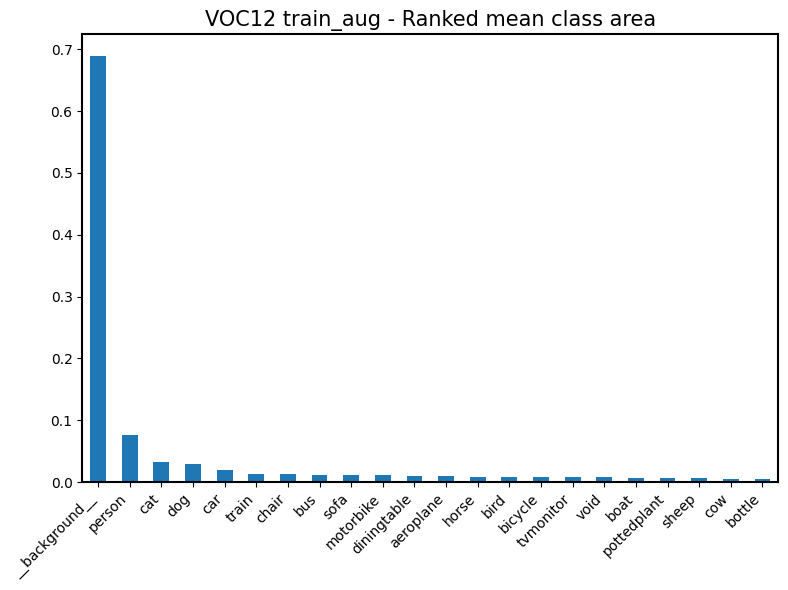

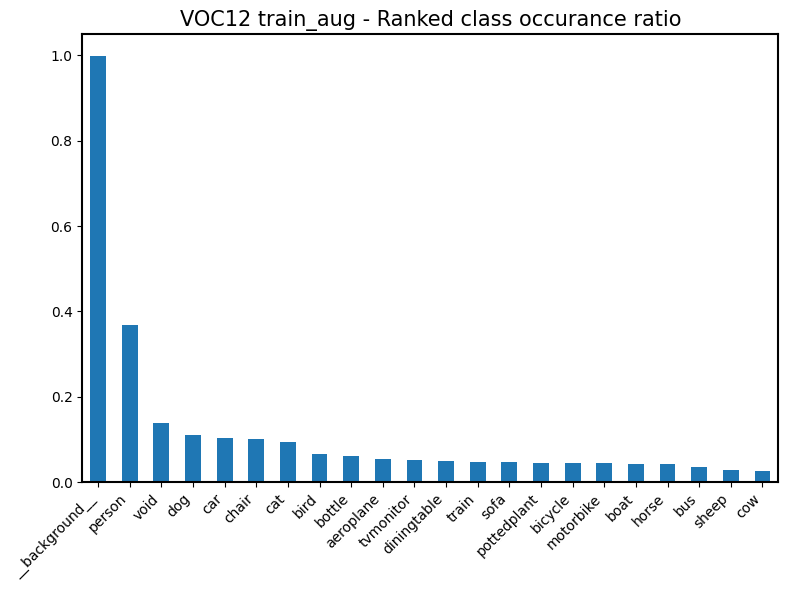

Remove ['__background__']


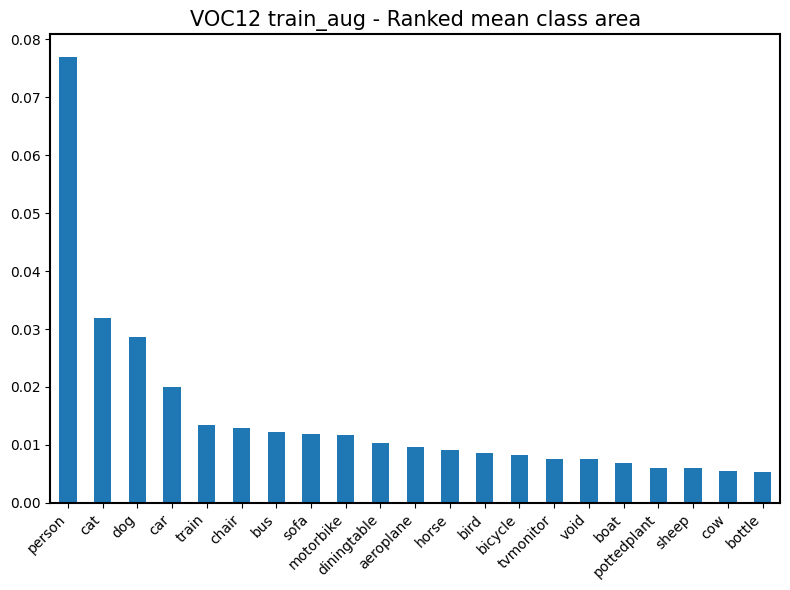

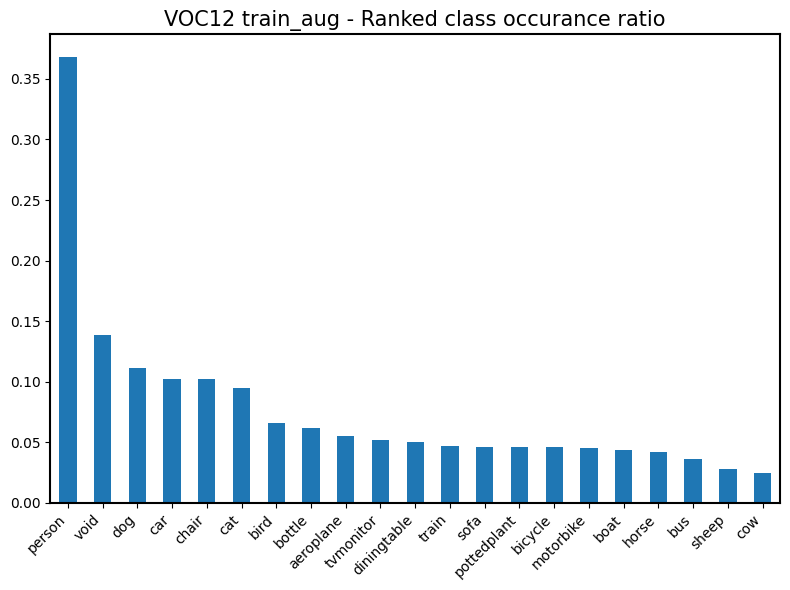

In [18]:
df_pascal_aug = df_pascal[df_pascal['split'] == 'train_aug'][PASCAL_CATEGORIES]
df = pd.DataFrame(df_pascal_aug)

ranked(df)

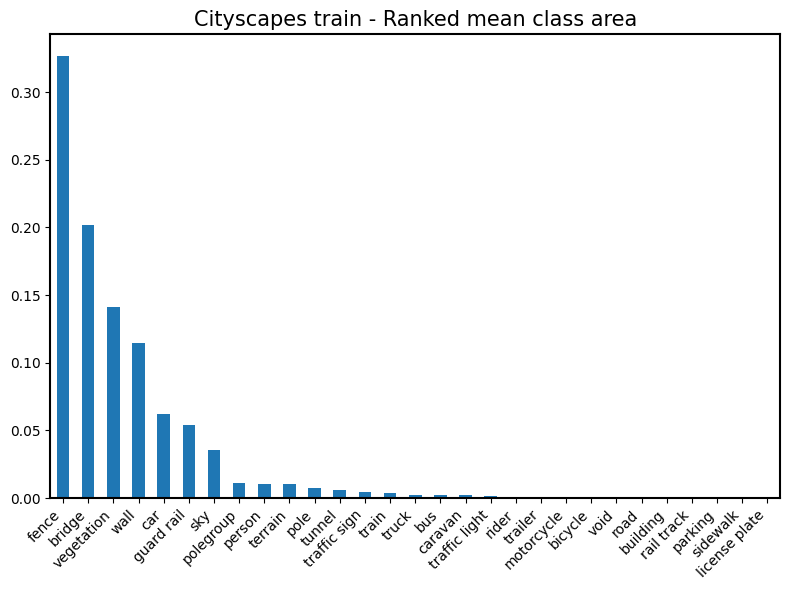

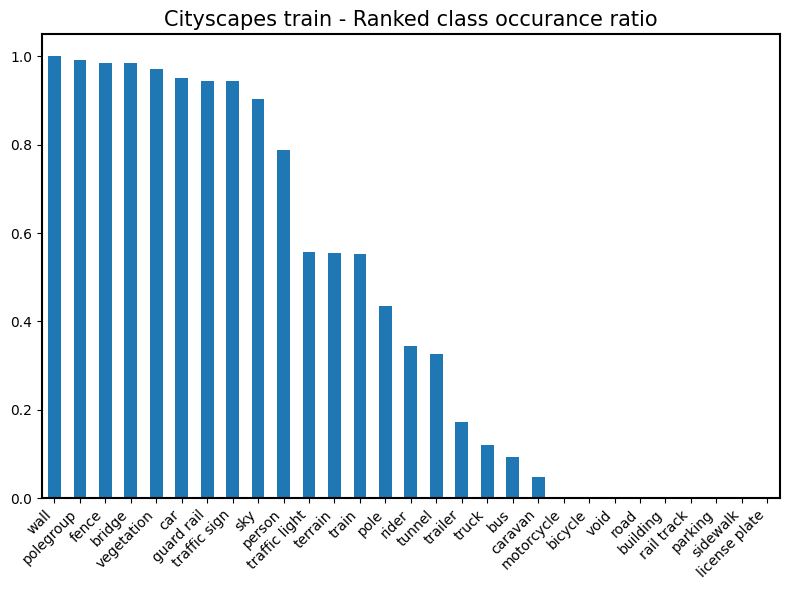

Remove []


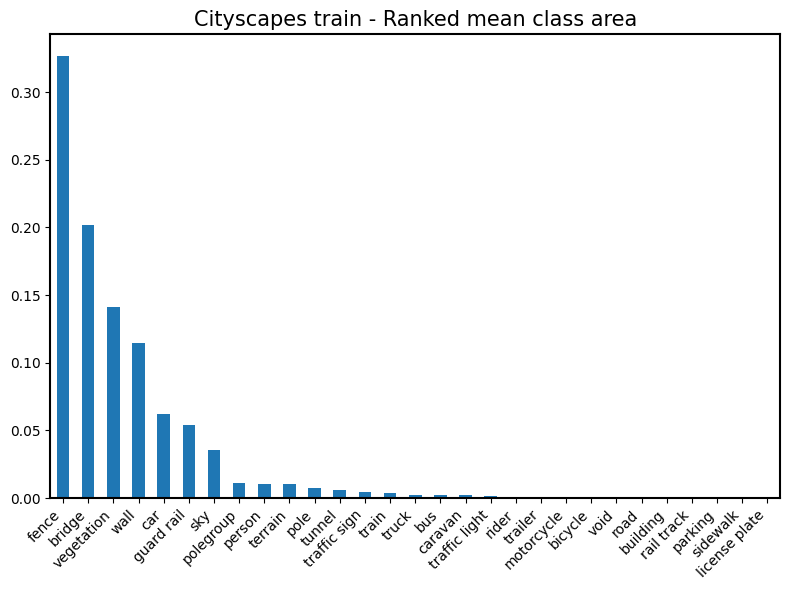

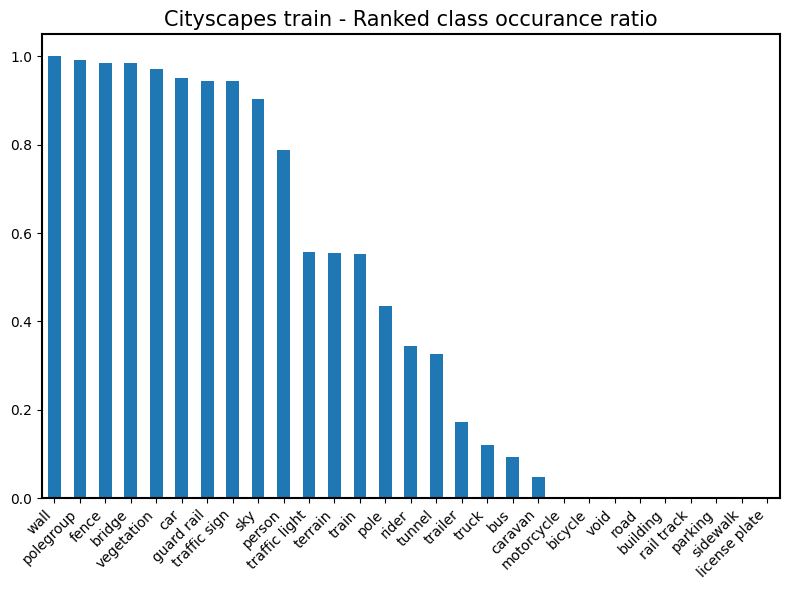

In [19]:
df_cs_train = df_cs[df_cs['split'] == 'train'][CITYSCAPES_CATEGORIES]
df = pd.DataFrame(df_cs_train)

ranked(df, title_prep='Cityscapes train - ', drop1=[], drop2=[])

In [58]:
df_cs

,void,road,sidewalk,parking,rail track,building,wall,fence,guard rail,bridge,...,truck,bus,caravan,trailer,train,motorcycle,bicycle,license plate,split,file
0,0.0,0.0,0.0,0.0,0.0,0.0,0.060959,0.396291,0.013921,0.291795,...,0.0,0.000000,0.0,0.000000,0.001101,0.0,0.0,0.0,train,../cityscapes/annotations/train/aachen_000000_...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.078133,0.402083,0.012169,0.202764,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,train,../cityscapes/annotations/train/aachen_000001_...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.063182,0.345419,0.076678,0.154130,...,0.0,0.000000,0.0,0.000000,0.000078,0.0,0.0,0.0,train,../cityscapes/annotations/train/aachen_000002_...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.056000,0.332195,0.089291,0.421351,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,train,../cityscapes/annotations/train/aachen_000003_...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.059792,0.442872,0.013548,0.301592,...,0.0,0.000000,0.0,0.000524,0.000721,0.0,0.0,0.0,train,../cityscapes/annotations/train/aachen_000004_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,0.0,0.0,0.0,0.0,0.0,0.0,0.056148,0.280806,0.141091,0.026357,...,0.0,0.051467,0.0,0.000029,0.000402,0.0,0.0,0.0,train,../cityscapes/annotations/train/zurich_000117_...
2971,0.0,0.0,0.0,0.0,0.0,0.0,0.065033,0.326429,0.145779,0.106670,...,0.0,0.000000,0.0,0.000051,0.018769,0.0,0.0,0.0,train,../cityscapes/annotations/train/zurich_000118_...
2972,0.0,0.0,0.0,0.0,0.0,0.0,0.070061,0.314523,0.125698,0.210262,...,0.0,0.070919,0.0,0.007959,0.000000,0.0,0.0,0.0,train,../cityscapes/annotations/train/zurich_000119_...
2973,0.0,0.0,0.0,0.0,0.0,0.0,0.064165,0.313607,0.109024,0.045351,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,train,../cityscapes/annotations/train/zurich_000120_...


In [66]:
import json
path = '../cityscapes/gtFine_trainvaltest/gtFine/train/'
fence_p = []
for f in df_cs['file']:
    split1 = f.split('/')

    citydir = split1[-1].split('_')[0]

    file=path+citydir+'/'+split1[-1].split('.')[0]+'_gtFine_polygons.json'
    
    # Open the JSON file
    with open(file) as f:
        data = json.load(f)

    labels = [obj['label'] for obj in data['objects']]

    fence_part = 1 if labels.count('fence') > 0 else 0 
    fence_p.append(fence_part)
  
    
print(fence_p)
print(sum(fence_p)/len(fence_p))

[0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 